In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from matplotlib.font_manager import FontProperties
import pickle as pkl
import sys
import os
sys.path.append('/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/Model_utils/')
import other_billeh_utils
from tqdm import tqdm
import pandas as pd
from scipy.fft import fft

font = FontProperties()
font.set_weight('bold')

colors = ['darkviolet', 'lightseagreen', 'goldenrod']
labels = ['V1', 'LGN', 'LM']

num_v1_neurons = 51978
num_lgn_neurons = 17400
num_lm_neurons = 7414

# Load model
cache_path = '/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/Model_utils/.cache/lm_v1_network_v1_100000_lm_30000.pkl'
with open(cache_path, 'rb') as f:
    networks, lgn_inputs, bkg_inputs = pkl.load(f)

2024-10-08 19:12:49.527879: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-08 19:12:49.569273: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 19:12:49.569340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 19:12:49.570270: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-08 19:12:49.576614: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-08 19:12:49.577598: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
# Filters for selecting only the excitatory neurons and having them classified in layers
# networks['v1'].keys() to visualize the keys of the dictionary

# obtain the neuron type of each neuron 
new_pop_names = other_billeh_utils.pop_names(networks['v1'], n_selected_neurons=51978, data_dir='/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/GLIF_network')
cell_types_v1 = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in new_pop_names]

new_pop_names = other_billeh_utils.pop_names(networks['lm'], n_selected_neurons=7414, data_dir='/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/GLIF_network')
cell_types_lm = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in new_pop_names]

cell_types = [cell_types_v1, cell_types_lm]

unique_cell_types = list(set(cell_types_v1))
unique_cell_types = sorted(unique_cell_types)

# Do a mask for exc. + inh. for each layer of each region
layer_mask_v1 = [[cell_type.startswith(f'L{i}') for cell_type in cell_types[0]] for i in ["1","2/3","4","5","6"]]
layer_mask_lm = [[cell_type.startswith(f'L{i}') for cell_type in cell_types[1]] for i in ["1","2/3","4","5","6"]]

# Do a mask for neuron types in each layer of each region 
# The unique neuron types are stored in unique_cell_types
layer_mask_v1_types = [[cell_type == unique_cell_types[i] for cell_type in cell_types[0]] for i in range(len(unique_cell_types))]
layer_mask_lm_types = [[cell_type == unique_cell_types[i] for cell_type in cell_types[1]] for i in range(len(unique_cell_types))]

# Load data

In [3]:
# WHITE CONNECTED
# Path to the data file
data_file = 'Data/simulation_data.hdf5'

# Open the file in read mode
file = h5py.File(data_file, 'r')

# Access the 'Data' group
data_group = file['Data']

# Initialize a dictionary to hold the data
data = {}

# Loop over the subgroups ('v1', 'lm', 'LGN')
for subgroup_name in data_group.keys():
    # Access the subgroup
    subgroup = data_group[subgroup_name]
    
    # Access the 'z' dataset in the subgroup
    dataset = subgroup['z']
    
    # Convert the dataset to a numpy array and store it in the dictionary
    data[subgroup_name] = np.array(dataset)

# Close the file
file.close()

data_v1 = data['v1']
data_lm = data['lm']
data_lgn = data['LGN']

# Save the data
np.save('Data/data_v1.npy', data_v1)
np.save('Data/data_lm.npy', data_lm)
np.save('Data/data_lgn.npy', data_lgn)

print('Data loaded')

Data loaded


In [13]:
# Load the data
data_v1 = np.load('Data/data_v1.npy')
data_lm = np.load('Data/data_lm.npy')
data_lgn = np.load('Data/data_lgn.npy')

# remove first 100 ms
data_v1 = data_v1[:,100:,:]
data_lm = data_lm[:,100:,:]
data_lgn = data_lgn[:,100:,:]

# print shapes
print(data_v1.shape)
print(data_lm.shape)
print(data_lgn.shape)

(100, 800, 51978)
(100, 800, 7414)
(100, 800, 17400)


# Compute power spectrum population-wise

In [14]:
power_spectra_v1 = {}
power_spectra_lm = {}
power_spectra_lgn = {}

# V1
for neuron_type in tqdm(unique_cell_types):
    # Find indices of this neuron type
    neuron_indices = np.where(np.array(cell_types_v1) == neuron_type)[0]

    # Accumulate the spike data for these neurons across trials to compute population
    # power spectra
    spikes_for_type = data_v1[:,:,neuron_indices].sum(axis=2)

    # Average across trials
    avg_spikes_train = np.mean(spikes_for_type, axis=0)

    # Apply FFT and compute power spectrum
    fft_ = fft(avg_spikes_train)
    power_spectrum = np.abs(fft_)**2

    # Store the power spectrum for this type
    power_spectra_v1[neuron_type] = power_spectrum

# Total power spectrum across all V1 neurons
total_spikes = data_v1.sum(axis=2).mean(axis=0)
fft_total = fft(total_spikes)
power_spectra_v1_total = np.abs(fft_total)**2

# LM
for neuron_type in tqdm(unique_cell_types):
    # Find indices of this neuron type
    neuron_indices = np.where(np.array(cell_types_lm) == neuron_type)[0]

    # Accumulate the spike data for these neurons across trials to compute population
    # power spectra
    spikes_for_type = data_lm[:,:,neuron_indices].sum(axis=2)

    # Average across trials
    avg_spikes_train = np.mean(spikes_for_type, axis=0)

    # Apply FFT and compute power spectrum
    fft_ = fft(avg_spikes_train)
    power_spectrum = np.abs(fft_)**2

    # Store the power spectrum for this type
    power_spectra_lm[neuron_type] = power_spectrum

# Total power spectrum across all LM neurons
total_spikes = data_lm.sum(axis=2).mean(axis=0)
fft_total = fft(total_spikes)
power_spectra_lm_total = np.abs(fft_total)**2


100%|██████████| 17/17 [00:01<00:00, 10.69it/s]


# Plotting

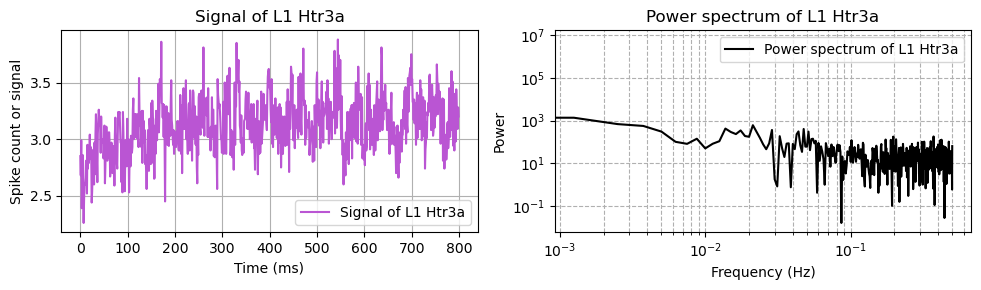

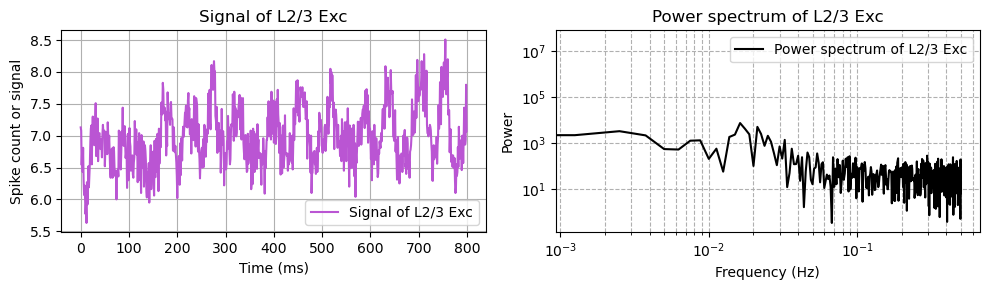

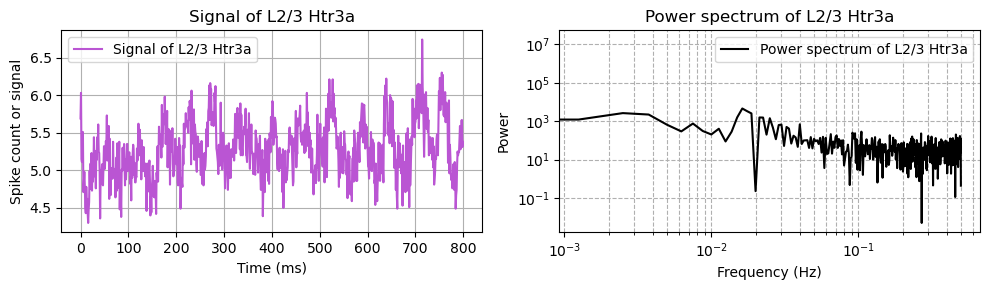

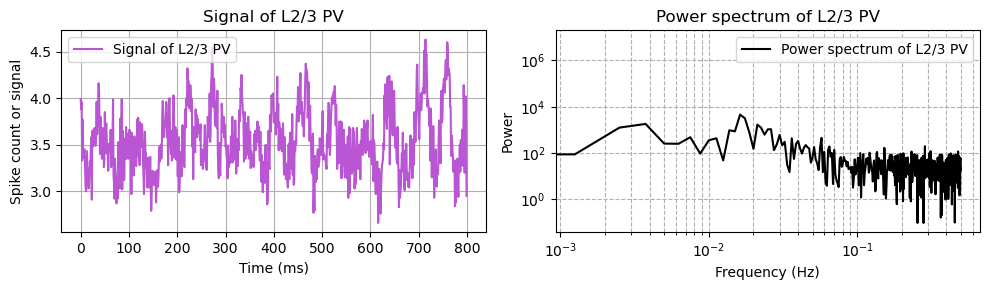

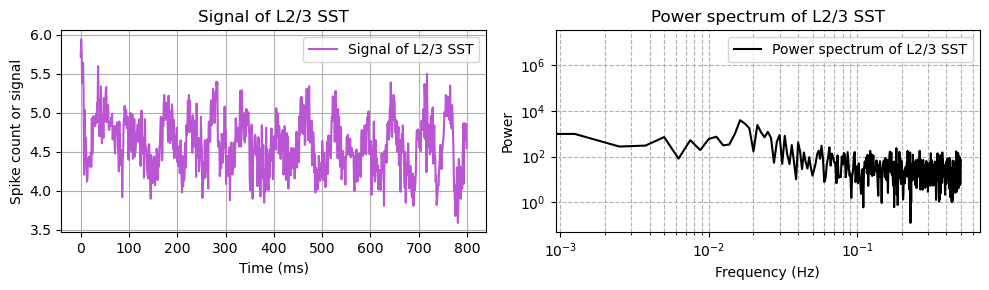

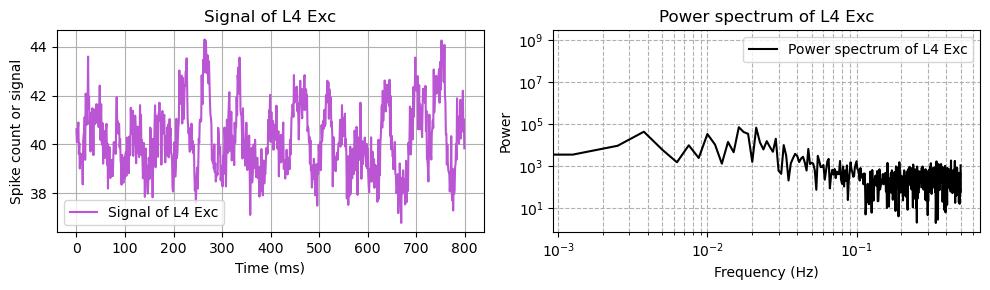

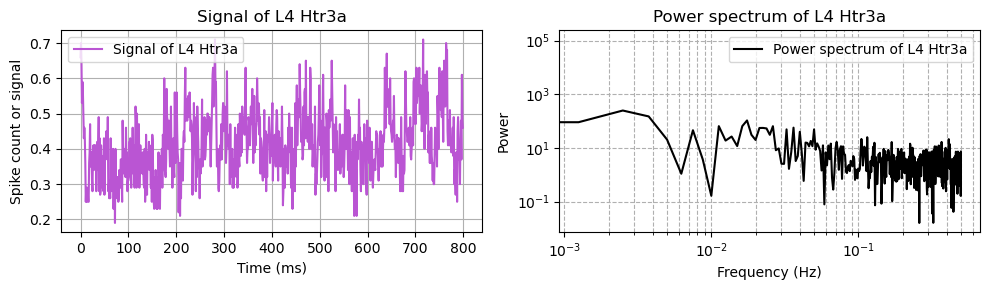

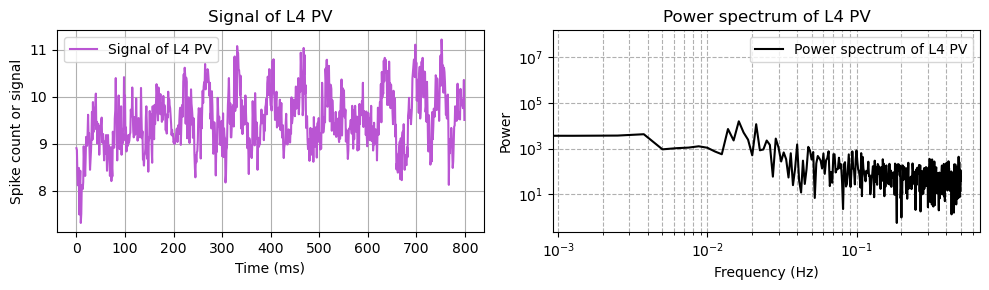

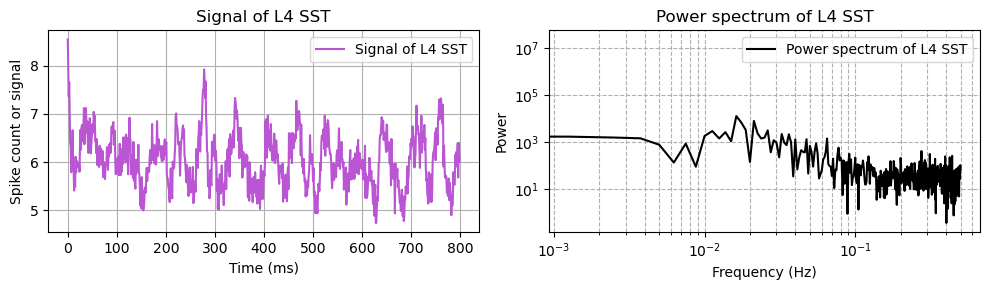

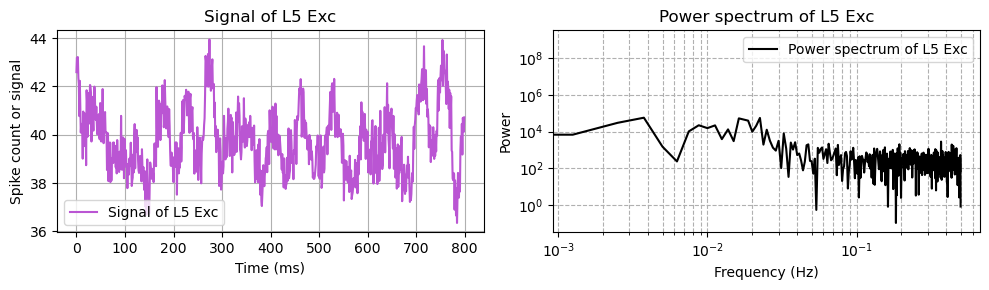

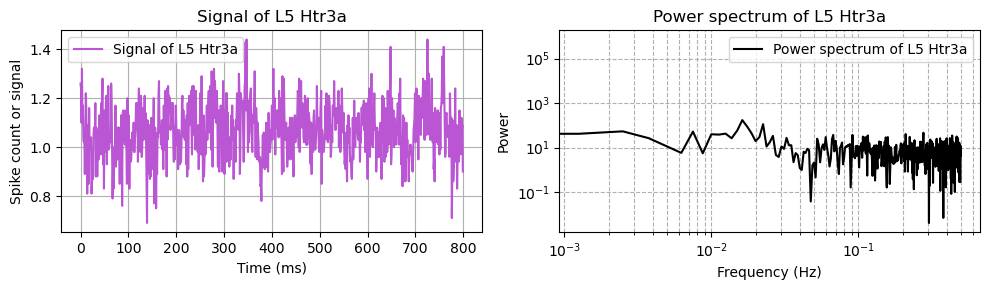

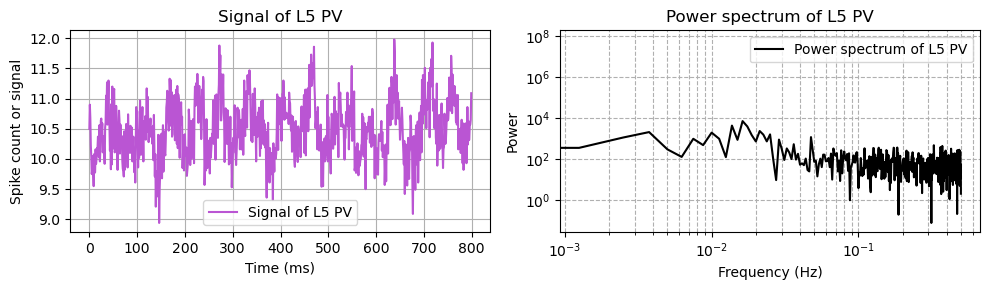

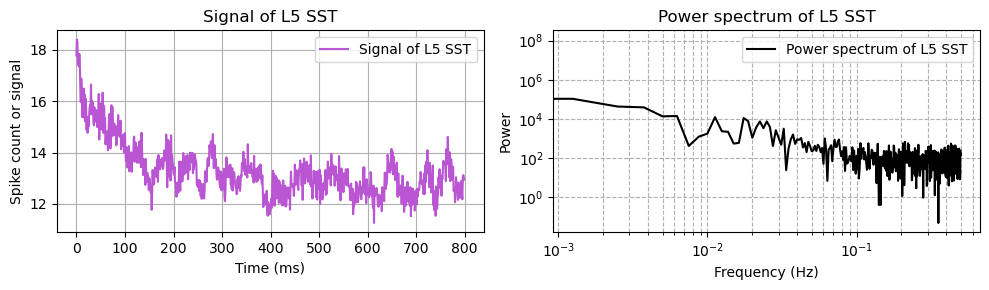

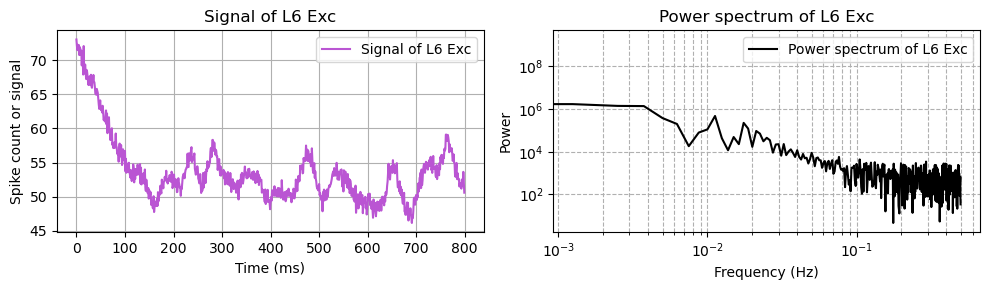

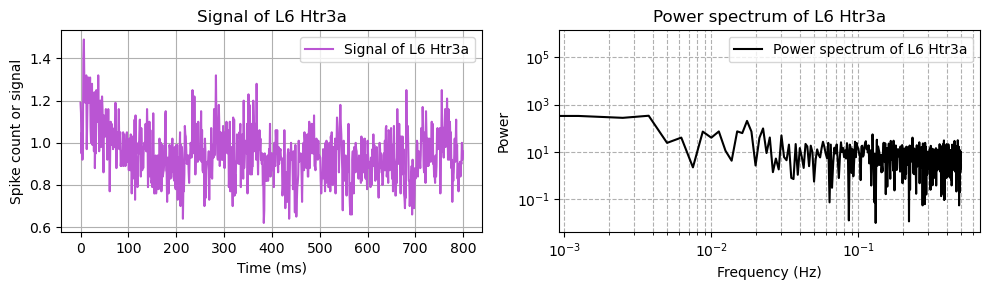

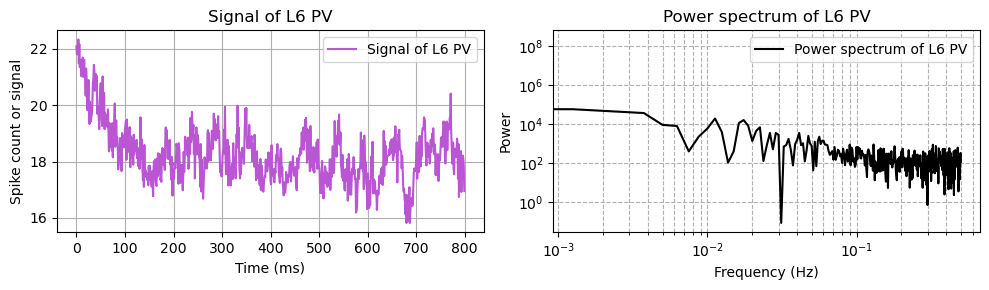

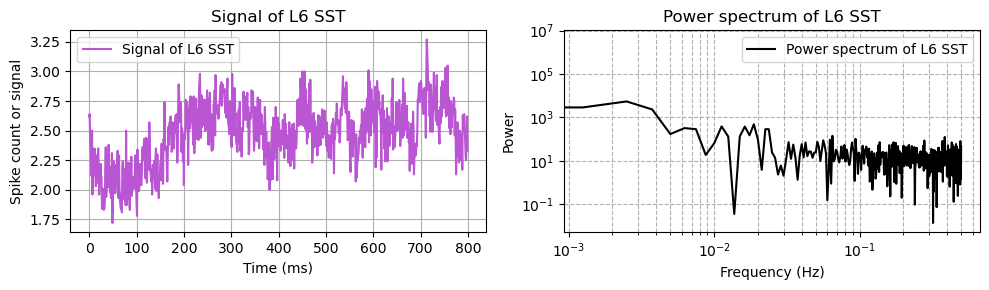

In [15]:
# For each neuron type in V1
n_timepoints = data_v1.shape[1]
freqs = np.fft.fftfreq(n_timepoints, d=1.0)[:n_timepoints // 2]  # Only take positive frequencies

# Plot the power spectrum for each neuron type
for neuron_type, power_spectrum in power_spectra_v1.items():
    # Find indices of this neuron type
    neuron_indices = np.where(np.array(cell_types_v1) == neuron_type)[0]

    # Accumulate the spike data for these neurons across trials to compute population
    # power spectra
    spikes_for_type = data_v1[:,:,neuron_indices].sum(axis=2)

    # Average across trials
    avg_signal = np.mean(spikes_for_type, axis=0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3)) 

    # Plot the original signal in the left subplot
    ax1.plot(range(n_timepoints), avg_signal, color='mediumorchid', label='Signal of ' + neuron_type)
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Spike count or signal')
    ax1.set_title('Signal of ' + neuron_type)
    ax1.legend()
    ax1.grid(True)

    # Plot the power spectrum in the right subplot
    ax2.plot(freqs, power_spectrum[:n_timepoints // 2], color='black', label='Power spectrum of ' + neuron_type)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Power')
    ax2.set_title('Power spectrum of ' + neuron_type)
    ax2.legend()
    ax2.grid(True, which="both", ls="--")

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [ ]:
# Now plotting for LM
# For each neuron type in LM
n_timepoints = data_lm.shape[1]
freqs = np.fft.fftfreq(n_timepoints, d=1.0)[:n_timepoints // 2]  # Only take positive

# Plot the power spectrum for each neuron type
for neuron_type, power_spectrum in power_spectra_lm.items():
    # Find indices of this neuron type
    neuron_indices = np.where(np.array(cell_types_lm) == neuron_type)[0]

    # Accumulate the spike data for these neurons across trials to compute population
    # power spectra
    spikes_for_type = data_lm[:,:,neuron_indices].sum(axis=2)

    # Average across trials
    avg_signal = np.mean(spikes_for_type, axis=0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3)) 

    # Plot the original signal in the left subplot
    ax1.plot(range(n_timepoints), avg_signal, color='mediumorchid', label='Signal of ' + neuron_type)
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Spike count or signal')
    ax1.set_title('Signal of ' + neuron_type)
    ax1.legend()
    ax1.grid(True)

    # Plot the power spectrum in the right subplot
    ax2.plot(freqs, power_spectrum[:n_timepoints // 2], color='black', label='Power spectrum of ' + neuron_type)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Power')
    ax2.set_title('Power spectrum of ' + neuron_type)
    ax2.legend()
    ax2.grid(True, which="both", ls="--")

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
